# MovieLens Project Part 1: Exploratory Data Analysis on 100K Dataset

As part of a project sponsored by the data science team at [Air Liquide](https://www.airliquide.com/) here in Philadelphia, I'm diving deep into collaborative filtering algorithms. There are 2 main goals of this project:

1. Gain understanding of a variety of collaborative filtering algorithms by implementing them myself
2. Compare quality and speed of a variety of algorithms as a function of dataset size

The data I'm using comes from the [GroupLens](https://grouplens.org/) research group, who has been collecting movie ratings from volunteers since 1995 and has curated datasets of a variety of sizes. For the initial development phase of the project, I'll focus on the 100K dataset, the smallest one, to enable faster iteration. I'll scale up to larger datasets later on.

Before getting into any algorithm development, I want to get a picture of the data I'm working with, so I'll ask the questions on my mind and try to answer them with the data.

## Get the data

In [1]:
!mkdir -p raw
!curl -O http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip -o ml-100k.zip -d raw/
!rm ml-100k.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4808k  100 4808k    0     0  1783k      0  0:00:02  0:00:02 --:--:-- 1783k
Archive:  ml-100k.zip
  inflating: raw/ml-100k/allbut.pl   
  inflating: raw/ml-100k/mku.sh      
  inflating: raw/ml-100k/README      
  inflating: raw/ml-100k/u.data      
  inflating: raw/ml-100k/u.genre     
  inflating: raw/ml-100k/u.info      
  inflating: raw/ml-100k/u.item      
  inflating: raw/ml-100k/u.occupation  
  inflating: raw/ml-100k/u.user      
  inflating: raw/ml-100k/u1.base     
  inflating: raw/ml-100k/u1.test     
  inflating: raw/ml-100k/u2.base     
  inflating: raw/ml-100k/u2.test     
  inflating: raw/ml-100k/u3.base     
  inflating: raw/ml-100k/u3.test     
  inflating: raw/ml-100k/u4.base     
  inflating: raw/ml-100k/u4.test     
  inflating: raw/ml-100k/u5.base     
  inflating: raw/ml-100k/u5.test     
  inflating: raw/

In [2]:
# <!-- collapse=True -->
%matplotlib inline
from datetime import datetime
from IPython.display import Markdown
from os.path import join
from os.path import exists
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Use modified seaborn-darkgrid style with bigger text
plt.style.use('big-darkgrid.mplstyle')

Let's load and examine the ratings data. I sort the data by `timestamp` and break the `timestamp` column out into `year` and `month` and display the first 5 and last 5 ratings in the dataset.

In [3]:
# <!-- collapse=True -->
ratings_df = pd.read_csv('raw/ml-100k/u.data', sep='\t', header=None, 
                         names=['userId', 'movieId', 'rating', 'timestamp'])
ratings_df['timestamp'] = ratings_df['timestamp'].apply(datetime.fromtimestamp)
ratings_df['year'] = ratings_df['timestamp'].dt.year
ratings_df['month'] = ratings_df['timestamp'].dt.month
ratings_df = ratings_df.sort_values('timestamp')
print('First 5:')
display(ratings_df.head())
print()
print('Last 5:')
display(ratings_df.tail())

First 5:


,userId,movieId,rating,timestamp,year,month
214,259,255,4,1997-09-19 23:05:10,1997,9
83965,259,286,4,1997-09-19 23:05:27,1997,9
43027,259,298,4,1997-09-19 23:05:54,1997,9
21396,259,185,4,1997-09-19 23:06:21,1997,9
82655,259,173,4,1997-09-19 23:07:23,1997,9



Last 5:


,userId,movieId,rating,timestamp,year,month
46773,729,689,4,1998-04-22 19:10:38,1998,4
73008,729,313,3,1998-04-22 19:10:38,1998,4
46574,729,328,3,1998-04-22 19:10:38,1998,4
64312,729,748,4,1998-04-22 19:10:38,1998,4
79208,729,272,4,1998-04-22 19:10:38,1998,4


We can see from these rows that this part of the dataset is user-movie-rating triplets at different points in time. Let's ask some questions about the data to get a feel for what we're working with:

# 1. How are the ratings distributed?

I'd like to see what ratings are common and uncommon, so let's just plot counts of each rating:

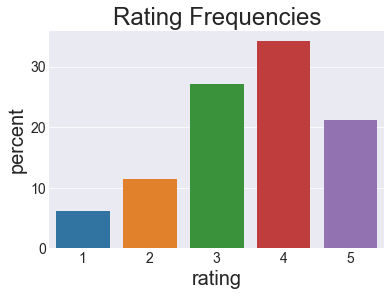

In [4]:
# <!-- collapse=True -->
norm_counts = (
    ratings_df['rating']
    .value_counts(normalize=True, sort=False)
    .multiply(100)
    .reset_index()
    .rename(columns={'rating': 'percent', 'index': 'rating'})
)
ax = sns.barplot(x='rating', y='percent', data=norm_counts)
ax.set_title('Rating Frequencies')
plt.show()

# 2. How many ratings were submitted per month?

,year,month,# of Ratings
Date,,,
1997-09-01,1997,9,6808
1997-10-01,1997,10,10368
1997-11-01,1997,11,24073
1997-12-01,1997,12,11695
1998-01-01,1998,1,14100
1998-02-01,1998,2,10961
1998-03-01,1998,3,12987
1998-04-01,1998,4,9008


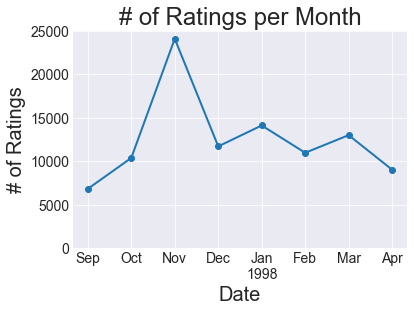

In [5]:
# <!-- collapse=True -->
month_counts = ratings_df[['year', 'month', 'rating']].groupby(['year', 'month']).count()
month_counts = month_counts.rename(index=str, columns={'rating': '# of Ratings'})
month_counts = month_counts.reset_index()
month_counts['Date'] = month_counts[['year', 'month']].apply(
    lambda x: datetime(year=int(x[0]), month=int(x[1]), day=1), axis=1
)
month_counts = month_counts.set_index('Date', drop=True)
display(month_counts)
month_counts['# of Ratings'].plot(style='o-')
plt.ylabel('# of Ratings')
plt.title('# of Ratings per Month')
plt.ylim([0, 25000])
plt.gca().grid(which='minor')
plt.show()

The number of ratings had a fairly large spike in November of 1998, but otherwise was relatively constant.

This leads to another question about changes over time:

# 5. How consistent are the average ratings over time?

,year,month,Rating,std
Date,,,,
1997-09-01,1997,9,3.541569,1.091807
1997-10-01,1997,10,3.594425,1.097959
1997-11-01,1997,11,3.558759,1.110674
1997-12-01,1997,12,3.578367,1.110067
1998-01-01,1998,1,3.397092,1.187497
1998-02-01,1998,2,3.456619,1.128093
1998-03-01,1998,3,3.548395,1.109802
1998-04-01,1998,4,3.576710,1.142116


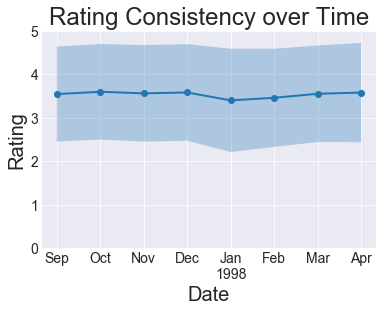

In [6]:
# <!-- collapse=True -->
month_counts = ratings_df.groupby(['year', 'month'])['rating'].agg([np.mean, np.std])
month_counts = month_counts.rename(index=str, columns={'mean': 'Rating'})
month_counts = month_counts.reset_index()
month_counts['Date'] = month_counts[['year', 'month']].apply(
    lambda x: datetime(year=int(x[0]), month=int(x[1]), day=1), axis=1
)
month_counts = month_counts.set_index('Date', drop=True)
display(month_counts)
month_counts['Rating'].plot(style='o-')
plt.fill_between(month_counts.index,
                 month_counts['Rating'] - month_counts['std'],
                 month_counts['Rating'] + month_counts['std'],
                 alpha=0.3,
                )
plt.ylim([0, 5])
plt.ylabel('Rating')
plt.gca().grid(which='minor')
plt.title('Rating Consistency over Time')
plt.show()

This average ratings were fairly consistent around 3.5. The lack of large changes over time will simplify modeling a little bit.

One last thing I'm curious about (for now) when it comes to changes over time:

# 6. How quickly do the movie and user bases grow over time?

I'll assume that a user has joined on her first rating, and that she remains a user from then on.

,userId,movieId,rating,timestamp,year,month,Date
214,259,255,4,1997-09-19 23:05:10,1997,9,1997-09-01
83965,259,286,4,1997-09-19 23:05:27,1997,9,1997-09-01
43027,259,298,4,1997-09-19 23:05:54,1997,9,1997-09-01
21396,259,185,4,1997-09-19 23:06:21,1997,9,1997-09-01
82655,259,173,4,1997-09-19 23:07:23,1997,9,1997-09-01


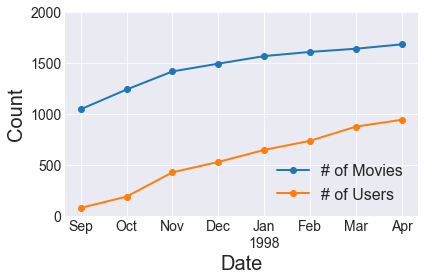

In [7]:
# <!-- collapse=True -->
ratings_df['Date'] = ratings_df[['year', 'month']].apply(
    lambda x: datetime(year=int(x[0]), month=int(x[1]), day=1), axis=1
)
display(ratings_df.head())
n_users = []
n_movies = []
dates = np.unique(ratings_df['Date'])
for date in dates:
    n_users.append(ratings_df[ratings_df['Date'] <= date]['userId'].nunique())
    n_movies.append(ratings_df[ratings_df['Date'] <= date]['movieId'].nunique())
df_users = pd.DataFrame({'Date': dates, '# of Users': n_users}).set_index('Date')
df_movies = pd.DataFrame({'Date': dates, '# of Movies': n_movies}).set_index('Date')
fig, ax = plt.subplots()
df_movies['# of Movies'].plot(style='o-', ax=ax)
df_users['# of Users'].plot(style='o-', ax=ax)
plt.ylabel('Count')
plt.ylim([0, 2000])
ax.grid(which='minor')
plt.tight_layout()
plt.legend()
plt.show()

New users seen in the dataset look fairly linear over time, although the number of movies start out withover 1000 already in the system.

# 7. How sparse is the user/movies matrix we'll be dealing with?

Sparsity is a very common challenge to overcome in many collaborative filtering applications. By sparsity, I mean that if we create a matrix $R$ with dimensions $n_{users} \times n_{movies}$ where each element $r_{ij}$ is a single rating by user $i$ of movie $j$, this matrix will be very empty because most users have only rated a few of the 25,000+ movies available. Let's see how bad it is.

Here's one way to visualize the sparsity. The plot below shows a single, tiny black square for every user/movie combination we have. If everyone rated every movie, you'd see a solid black rectangle. Instead what we see is a lot of white--lots of user/movie combinations for which we don't have a rating (yet). You especially see a lot of white in the top right corner. This is probably because early raters had access to fewer movies to rate, and new users progressively had more movies to rate as they were added to the system.



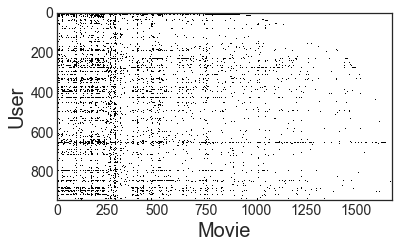

The matrix density is $n_{ratings}/(n_{users} \times n_{movies}) = 0.063$

In [8]:
# <!-- collapse=True -->
from cf_utils import get_rating_matrix
rating_matrix, user_map, item_map = get_rating_matrix(ratings_df)
with plt.style.context('seaborn-white'):
    rating_matrix_binary = rating_matrix > 0
    plt.imshow(rating_matrix_binary)
    plt.xlabel('Movie')
    plt.ylabel('User')
    plt.show()

Markdown(
    r"The matrix density is $n_{{ratings}}/(n_{{users}} \times n_{{movies}}) = {:0.3f}$"
    .format(np.sum(rating_matrix_binary) / np.prod(rating_matrix.shape))
)

In the plot above you also notice that there are a few darker rows and columns, but most rows and columns are pretty bare. Let's visualize the distributions of number of ratings by user and by movie. The way I chose to visualize this is with an [Empirical Cumulative Distribution Function (ECDF) plot](https://www.youtube.com/watch?v=ap4mfGvgDsM). An ECDF plot has an advantage compared to a histogram that all data points can be plotted in a meaningful way, and no bin size has to be chosen to average arbitrary chunks of it. This is especially helpful with the long-tailed distributions here.

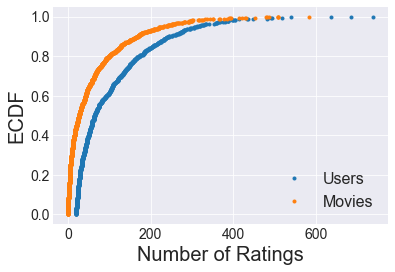

In [11]:
# <!-- collapse=True -->
user_counts = ratings_df['userId'].value_counts(ascending=True)
user_counts.index = np.arange(len(user_counts)) / len(user_counts)
plt.plot(user_counts, user_counts.index, '.', label='Users')
movie_counts = ratings_df['movieId'].value_counts(ascending=True)
movie_counts.index = np.arange(len(movie_counts)) / len(movie_counts)
plt.plot(movie_counts, movie_counts.index, '.', label='Movies')
plt.xlabel('Number of Ratings')
plt.ylabel('ECDF')
plt.legend()
plt.show()

In the plot above, you can learn, for example, that 40% of all users rated 50 or less movies, and 90% of movies have 169 or less ratings. In general, we seen that a large fraction of movies and users have few ratings associated with them, but a few movies and users have many more ratings.

The main thing to take from this though is that the matrix of possible ratings is quite sparse, and that we need to use models that deal with this lack of data.